In [5]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import RSLPStemmer
nltk.download('wordnet')
from markupsafe import escape
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow import keras
import keras
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder


# model building imports
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers import Conv1D, SimpleRNN, Bidirectional, MaxPooling1D, GlobalMaxPool1D, LSTM, GRU
from keras.models import Sequential
from keras.regularizers import L1L2

%matplotlib inline

# matplotlib defaults
plt.style.use("ggplot")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

import warnings 
warnings.filterwarnings('ignore')
nltk.download('omw-1.4')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\igorm\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\igorm\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [6]:
#Ver como o dado foi armazenado
data = pd.read_csv('noticias.csv', sep=';')
data.head()

,author,title,description,url,source,image,category,language,country,published_at,empresa
0,Felipe Moreira,"3R Petroleum (RRRP3) tem alta de 9,1% na produ...","Produção média diária da 3R somou 56,5 mil bar...",https://www.infomoney.com.br/mercados/3r-petro...,InfoMoney,NaN,business,pt,br,2024-01-08T11:41:10+00:00,Petrobras
1,Felipe Moreira,Petrobras (PETR4) comunica não renovação de li...,Acordo se iniciou em 28 de junho de 2019 e se ...,https://www.infomoney.com.br/mercados/petrobra...,InfoMoney,NaN,business,pt,br,2024-01-10T12:04:30+00:00,Petrobras
2,camillebocanegra,"XP revisa ações de geradoras, rebaixa AES (AES...",Research da XP destaca que excesso de oferta d...,https://www.infomoney.com.br/mercados/xp-revis...,InfoMoney,NaN,business,pt,br,2024-01-12T13:14:47+00:00,Petrobras
3,Lara Rizério,Mais um navio é alvo de ataque no Mar Vermelho...,Os navios que fornecem gás natural liquefeito ...,https://www.infomoney.com.br/mundo/mais-um-nav...,InfoMoney,NaN,business,pt,br,2024-01-16T16:39:18+00:00,Petrobras
4,Estadão Conteúdo,"Ibovespa tem instabilidade, mas defende os 132...",A valorização veio após as ações da Petrobras ...,https://www.infomoney.com.br/mercados/ibovespa...,InfoMoney,NaN,business,pt,br,2024-01-03T15:23:45+00:00,Petrobras


In [7]:
#data.info()
data.describe()

,author,title,description,url,source,image,category,language,country,published_at,empresa
count,3508,3550,3550,3550,3550,24,3550,3550,3550,3550,3550
unique,61,3165,3136,3182,8,21,4,1,1,3184,3
top,Esporte News Mundo,Jogadores dos Suns quase brigam no banco de re...,Jogadores dos Suns quase brigam no banco de re...,http://espn.uol.com.br/noticia/576889_jogadore...,InfoMoney,https://s2-g1.glbimg.com/OxSRAdHC7Tsq40BlEy9aG...,business,pt,br,2024-02-19T13:10:13+00:00,Banco do Brasil
freq,383,8,8,8,1409,2,1428,3550,3550,3,2347


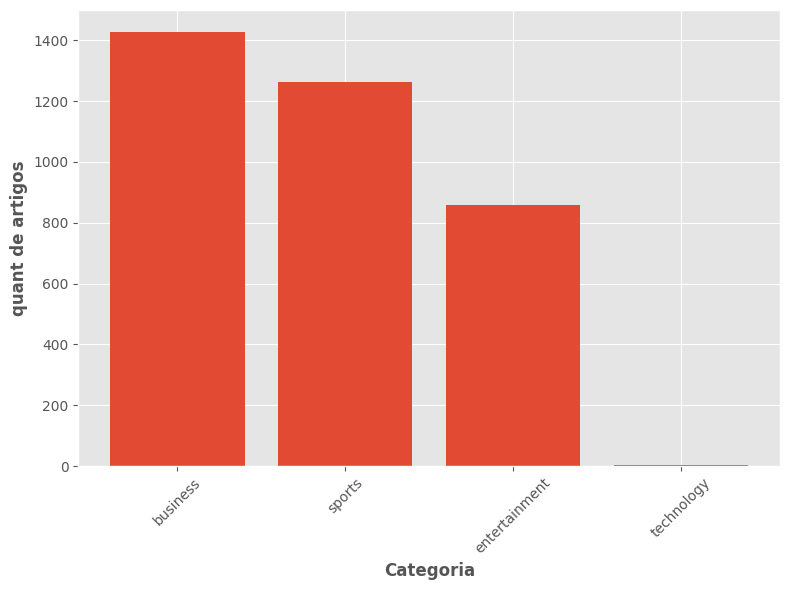

In [8]:
#Analisar as categorias dos artigos
category_counts = data.category.value_counts()

plt.figure(figsize=(8,6))
plt.bar(category_counts.index[:10], category_counts.values[:10])
plt.xlabel('Categoria')
plt.ylabel('quant de artigos')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

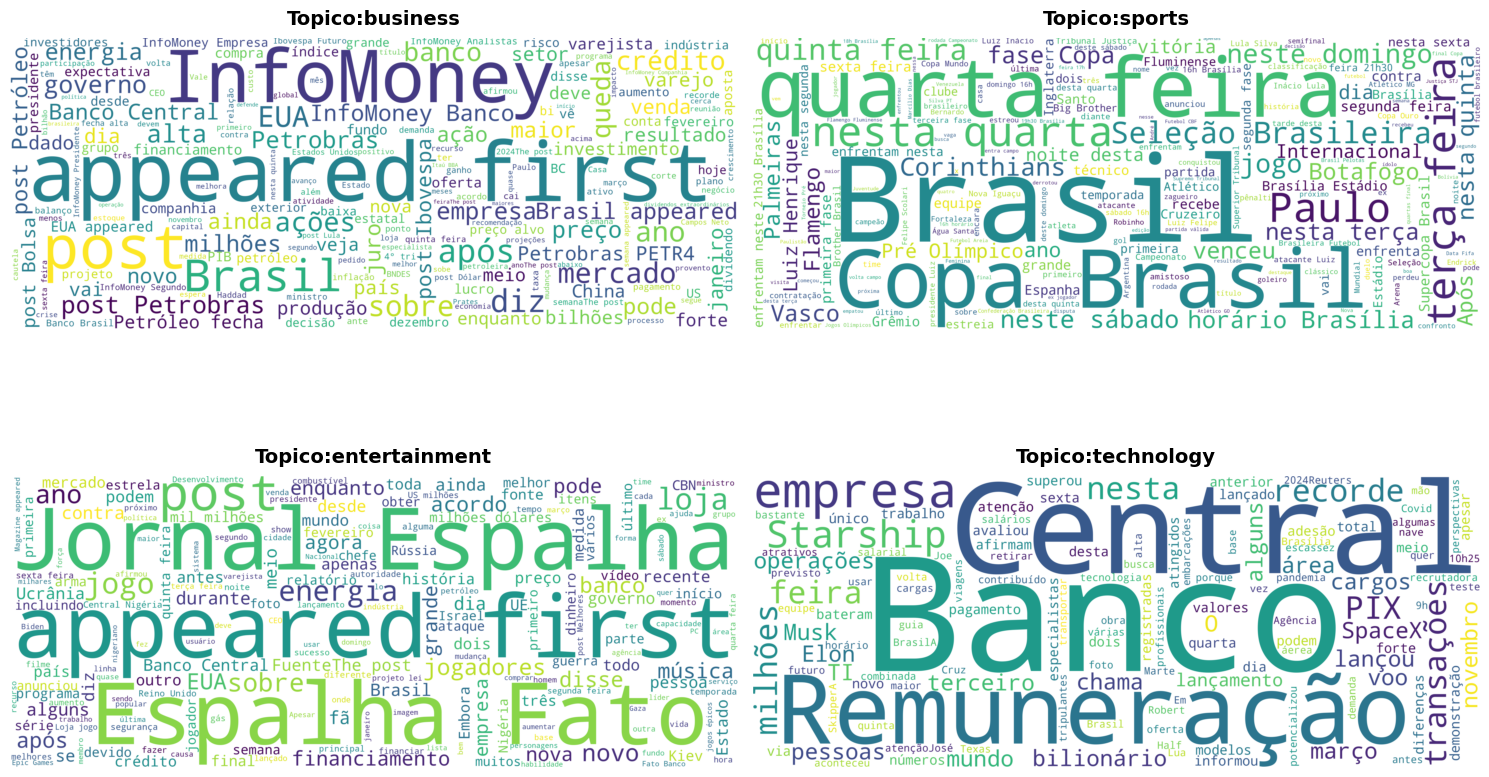

In [9]:
# Função para criar o wordcloud com remoção de stopwords
def create_wordcloud(category, text_column, ax):
    # Obtenha apenas o texto relevante para a categoria
    words = " ".join(data[data["category"] == category][text_column])
    
    # Tokenize o texto
    tokens = word_tokenize(words)
    
    # Remova as stopwords
    stop_words = set(stopwords.words('portuguese'))
    tokens_sem_stopwords = [word for word in tokens if word.lower() not in stop_words]
    
    # Reconstrua o texto sem as stopwords
    words_sem_stopwords = ' '.join(tokens_sem_stopwords)
    
    # Crie o wordcloud
    wordcloud = WordCloud(width=4000, height=1600, background_color="white").generate(words_sem_stopwords)
    
    # Exiba o wordcloud
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.set_title(f'Topico:{category}')
    ax.axis("off")

#  Observe que você precisa ter "data" definido antes de usar esta função
#  "data" deve ser um DataFrame contendo as colunas "category" e "description"

# Obtenha os top 4 categorias eficientemente
top_categories = data["category"].value_counts().head(4).index.to_list()

# Crie a figura e os subplots (ajuste nrows, ncols conforme necessário)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Itere e plote usando as top categorias
for i, category in enumerate(top_categories):
    ax = axes.flat[i]
    create_wordcloud(category, "description", ax)

plt.tight_layout()
plt.show()

# Processando os dados

In [10]:
' appeared first on InfoMoney.'

def preprocess_text(text):

    # Remove a frase específica
    text = text.replace('appeared first on InfoMoney', '')

    # Letras minúsculas para não diferenciar maiúsculas de minúsculas
    text = text.lower()
    
    # Remove espaços em branco extras (incluindo vários espaços)
    text = re.sub(r'\s+', ' ', text)

    # Remove URLs 
    text = re.sub(r"(?:\w+:\/\/\S+)", "", text)

    # Remove usernames 
    text = re.compile(r"(?i)@[a-z0-9_]+").sub('', text)

    # Remove HTML tags 
    text = re.sub(r"<[^>]*>", "", text)

    # Remove caracteres não alfanuméricos
    text = re.sub(r"[^\w\s]", "", text)  

    # Tokenização
    words = nltk.word_tokenize(text, language='portuguese')

    # Remoção de stopwords
    stop_words = set(stopwords.words('portuguese')) 
    text = [word for word in words if word not in stop_words]

    # Lemmatization (optional but can improve accuracy)
    lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text]

    return ' '.join(text)


In [11]:
print("Texto antes do pre-processing:\n",data['description'][0])
print("---"*35)
print("Texto depois do pre-processing:\n",preprocess_text(data['description'][0]))

Texto antes do pre-processing:
 Produção média diária da 3R somou 56,5 mil barris de óleo equivalente em dezembro de 2023The post 3R Petroleum (RRRP3) tem alta de 9,1% na produção do 4º trimestre de 2023 appeared first on InfoMoney.
---------------------------------------------------------------------------------------------------------
Texto depois do pre-processing:
 produção média diária 3r somou 565 mil barris óleo equivalente dezembro 2023the post 3r petroleum rrrp3 alta 91 produção 4º trimestre 2023


In [12]:
#fazendo alteracoes na database
data_final = data.copy()
data_final.drop(columns=['author'], inplace=True)
data_final.drop(columns=['title'], inplace=True)
data_final.drop(columns=['url'], inplace=True)
data_final.drop(columns=['source'], inplace=True)
data_final.drop(columns=['image'], inplace=True)
data_final.drop(columns=['category'], inplace=True)
data_final.drop(columns=['language'], inplace=True)
data_final.drop(columns=['country'], inplace=True)
data_final.drop(columns=['published_at'], inplace=True)
data_final.drop(columns=['empresa'], inplace=True)
				

data_final['description'] = data_final['description'].apply(preprocess_text)

data_final.head()


,description
0,produção média diária 3r somou 565 mil barris ...
1,acordo iniciou 28 junho 2019 encerrará 28 junh...
2,research xp destaca excesso oferta energia dev...
3,navios fornecem gás natural liquefeito gnl cat...
4,valorização veio após ações petrobras irem cam...


In [13]:
#Checar o antes e o depois da quantidade de palavras
old_len = data['description'].apply(lambda x: len([i for i in x.split()])).sum()
new_len = data_final['description'].apply(lambda x: len([i for i in x.split()])).sum()

print(f'Antes: {old_len}')
print(f'Depois: {new_len}')


Antes: 143633
Depois: 88777


# Tokenização e vetorização dos dados
### Refazendo o pre precessamento


In [16]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

def enhanced_clean(text):

  #Extra: Remove a frase específica
  text = text.replace('appeared first on InfoMoney', '')

  # Passo 1: Deixar tudo em minúsculas para insensibilidade a maiúsculas
  text = text.lower()
  # Converter todos os caracteres para minúsculas para análise consistente.

  # Passo 2: Limpeza Eficiente com Expressões Regulares
  text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*|[^\w\s]|[\[\]])", "", text)
  # Isso remove elementos indesejados como nomes de usuário, hashtags, URLs, pontuação e texto entre colchetes.

  # Passo 3: Remover Espaços Extras
  text = re.sub(r'\s+', ' ', text)
  # Substituir sequências de espaços em branco por um único espaço.

  # Passo 4: Tokenização Considerando Números e Palavras (Melhorado)
  token_pattern = r"(?u)\b\w+\b|\b\d{1,}\b|\w+[\w\'\-]*\w+"
  tokens = re.findall(token_pattern, text)
  # Isso divide o texto em tokens (palavras) usando uma expressão regular aprimorada:
  # - Pega caracteres de palavras com limites de palavra (`\b\w+\b`) para palavras completas.
  # - Captura sequências de dígitos (`\b\d{1,}\b`) como tokens únicos usando limites de palavra e exigindo pelo menos um dígito (`{1,}`). Isso garante que números com múltiplos dígitos como "23" sejam tratados como um todo.
  # - Considera palavras com hífen e apóstrofos (`\w+[\w\'\-]*\w+`) com a bandeira `(?u)` para compatibilidade com unicode.

  # Passo 5: Remoção de Palavras Vazias e Lematização (Opcional)
  stop_words = stopwords.words("portuguese")
  lemmatizer = WordNetLemmatizer()
  cleaned_tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens if word not in stop_words]
  # Esta parte é opcional. Remove palavras vazias e lematiza os tokens restantes.

  # Passo 6: Juntar Tokens Limpos e Corrigir Combinações Número-Palavra
  cleaned_text = " ".join(cleaned_tokens)
  # Percorra os tokens (palavras) após dividir o texto limpo
  for i in range(len(cleaned_text.split()) - 1):
    # Verifique se o token atual é um dígito e o próximo é alfabético (letra)
    if cleaned_text.split()[i].isdigit() and cleaned_text.split()[i+1].isalpha():
      # Se a combinação número-palavra for encontrada, insira um espaço entre elas
      cleaned_text = cleaned_text[:i+1] + " " + cleaned_text[i+1:]

  return cleaned_text

data_final_cleaned = data.copy()
columns_to_drop = ['author', 'title', 'url', 'source', 'image', 'category', 'language', 'country', 'published_at', 'empresa']
data_final_cleaned.drop(columns=columns_to_drop, inplace=True)

data_final_cleaned['description'] = data_final_cleaned['description'].apply(preprocess_text)

# Função para realizar a análise de sentimento com NLTK
def analyze_sentiment_nltk(text):
    sid = SentimentIntensityAnalyzer()
    polarity_score = sid.polarity_scores(text)
    if polarity_score['compound'] > 0.05:
        return 'positive'
    elif polarity_score['compound'] < -0.05:
        return 'negative'
    else:
        return 'neutral'

# Aplique a análise de sentimento em 'description' usando NLTK
data_final_cleaned['predicted_sentiment_nltk'] = data_final_cleaned['description'].apply(analyze_sentiment_nltk)

data_final_cleaned.head(10)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\igorm\AppData\Roaming\nltk_data...


,description,predicted_sentiment_nltk
0,produção média diária 3r somou 565 mil barris ...,neutral
1,acordo iniciou 28 junho 2019 encerrará 28 junh...,neutral
2,research xp destaca excesso oferta energia dev...,positive
3,navios fornecem gás natural liquefeito gnl cat...,positive
4,valorização veio após ações petrobras irem cam...,neutral
5,energias limpa atualmente algumas menos dispen...,neutral
6,postagem x antigo twitter prate afirmou petrob...,neutral
7,arábia saudita reduziu preços venda oficiais t...,neutral
8,feriado eua diminuiu liquidez negociações bols...,neutral
9,empresa formou joint venture construção parque...,neutral


In [ ]:
for x in range(10):
    print(data_final_cleaned['description'][x] + ' ---> ' + data_final_cleaned['predicted_sentiment_lexicon'][x])

produção média diária 3r somou 565 mil barris óleo equivalente dezembro 2023the post 3r petroleum rrrp3 alta 91 produção 4º trimestre 2023 ---> neutral
acordo iniciou 28 junho 2019 encerrará 28 junho 2029the post petrobras petr4 comunica renovação licença marcas vibra vbbr3 ---> neutral
research xp destaca excesso oferta energia deve manter preços baixos impactar nome setor the post xp revisa ações geradoras rebaixa aes aesb3 serena srna3 preferida ---> positive
navios fornecem gás natural liquefeito gnl catar muitos navios sendo forçados navegar áfrica através cabo boa esperançathe post navio alvo ataque mar vermelho interrupção transporte fará preços subirem ---> positive
valorização veio após ações petrobras irem campo positivo seguindo petróleothe post ibovespa instabilidade defende 132 mil pontos ante divulgação ata fed ---> neutral
energias limpa atualmente algumas menos dispendiosas explica parte crescimentothe post ano energia limpa eólica solar baterias crescem apesar desafios

In [ ]:
# Vectorization 

from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#TF-IDF
def using_TF_IDF(X_train, X_test):
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)
    return X_train_vectorized, X_test_vectorized


#Usando keras para word embedding
def using_keras_word_embedding(X_train, X_test):

    X_vector = []

    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(X_train)

    sequence_train = tokenizer.text_to_sequences(X_train)
    sequence_test = tokenizer.text_to_sequences(X_test) 

    padded_train = pad_sequences(sequence_train, maxlen=100)
    X_vector.append(padded_train)
    padded_test = pad_sequences(sequence_test, maxlen=100)
    X_vector.append(padded_test)

    return X_vector


    


In [ ]:
data_final_cleaned_1000 = data_final_cleaned.iloc[:1000]
data_final_cleaned_1000.describe()

,description,predicted_sentiment_lexicon
count,1000,1000
unique,952,3
top,botafogo anunciou oficialmente contratação pon...,neutral
freq,3,853


In [ ]:
# Usando o modelo SVM de Machine Learning

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
def svm_model(data_final_cleaned):
    text = data_final_cleaned['description']
    sentiment = data_final_cleaned['predicted_sentiment_lexicon']

    X_train, X_test, y_train, y_test = train_test_split(text, sentiment, test_size=0.2, random_state=42)

    X_train_vectorized,  X_test_vectorized = using_TF_IDF(X_train, X_test)

    svm_model = SVC(kernel='linear')
    svm_model.fit(X_train_vectorized, y_train)

    y_pred = svm_model.predict(X_test_vectorized)


    accuracy = accuracy_score(y_test, y_pred)
    print(f"Precisão:{accuracy}")

    # Store predictions and evaluation metrics in a DataFrame
    output_data = pd.DataFrame({
        "Texto": X_test,
        'Real': y_test,
        'Predicted': y_pred
        
    })

    # Store the DataFrame to a CSV file
    output_data.to_csv('output_results.csv', index=False)
    

svm_model(data_final_cleaned_1000)

Precisão:0.895
